<a href="https://colab.research.google.com/github/marcelounb/Deep_Learning_with_python_JasonBrownlee/blob/master/24_Time_Series_Prediction_with_Multilayer_Perceptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The problem we are going to look at in this lesson is the international airline passengers prediction problem. This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations. The dataset is available for free from the DataMarket webpage as a CSV download1 with the filename international-airline-passengers.csv.

We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore when we load the dataset we can exclude the first column. The downloaded dataset also has footer information that we can exclude with the skipfooter argument to pandas.read csv() set to 3 for the 3 footer lines. Once loaded we can easily plot the whole dataset. The code to load and plot the dataset is listed below

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
# fix random seed for reproducibility
np.random.seed(7)

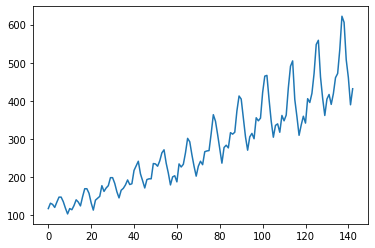

In [23]:
dataframe = pd.read_csv("/content/international-airline-passengers.csv", usecols=[1], delimiter=';')
plt.plot(dataframe)
plt.show()

In [24]:
dataframe

,112
0,118
1,132
2,129
3,121
4,135
...,...
138,606
139,508
140,461
141,390


In [25]:
dataset = dataframe.values
dataset = dataset.astype( 'float32' )
dataset

array([[118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [302.],
       [29

After we model our data and estimate the skill of our model on the training dataset, we
need to get an idea of the skill of the model on new unseen data. For a normal classification
or regression problem we would do this using k-fold cross validation. With time series data,
the sequence of values is important. A simple method that we can use is to split the ordered
dataset into train and test datasets. The code below calculates the index of the split point and
separates the data into the training datasets with 67% of the observations that we can use to
train our model, leaving the remaining 33% for testing the model.

In [26]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

95 48


Now we can define a function to create a new dataset as described above. The function takes
two arguments, the dataset which is a NumPy array that we want to convert into a dataset and
the look back which is the number of previous time steps to use as input variables to predict
the next time period, in this case, defaulted to 1. This default will create a dataset where X is
the number of passengers at a given time (t) and Y is the number of passengers at the next
time (t+1). It can be configured and we will look at constructing a differently shaped dataset
in the next section.

In [29]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [30]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [32]:
print(trainX, trainY)

[[118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]] [132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126. 141. 135.
 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163. 172. 178.
 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218. 230. 242.
 209. 191. 172. 194. 196. 196. 236. 235. 2

We can now fit a Multilayer Perceptron model to the training data. We use a simple network
with 1 input, 1 hidden layer with 8 neurons and an output layer. The model is fit using mean
squared error, which if we take the square root gives us an error score in the units of the dataset.
I tried a few rough parameters and settled on the configuration below, but by no means is the
network listed optimized.

In [34]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation= 'relu' ))
model.add(Dense(1))
model.compile(loss= 'mean_squared_error' , optimizer= 'adam' )
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 0s - loss: 47803.4284
Epoch 2/200
 - 0s - loss: 41909.5162
Epoch 3/200
 - 0s - loss: 35944.1748
Epoch 4/200
 - 0s - loss: 29811.8394
Epoch 5/200
 - 0s - loss: 23698.2323
Epoch 6/200
 - 0s - loss: 17970.5046
Epoch 7/200
 - 0s - loss: 12967.1977
Epoch 8/200
 - 0s - loss: 8773.7592
Epoch 9/200
 - 0s - loss: 5657.1323
Epoch 10/200
 - 0s - loss: 3489.4045
Epoch 11/200
 - 0s - loss: 2123.8840
Epoch 12/200
 - 0s - loss: 1299.1778
Epoch 13/200
 - 0s - loss: 890.2634
Epoch 14/200
 - 0s - loss: 683.6481
Epoch 15/200
 - 0s - loss: 598.2105
Epoch 16/200
 - 0s - loss: 558.5300
Epoch 17/200
 - 0s - loss: 548.1696
Epoch 18/200
 - 0s - loss: 543.8424
Epoch 19/200
 - 0s - loss: 543.7627
Epoch 20/200
 - 0s - loss: 541.1577
Epoch 21/200
 - 0s - loss: 543.2707
Epoch 22/200
 - 0s - loss: 550.7929
Epoch 23/200
 - 0s - loss: 548.8262
Epoch 24/200
 - 0s - loss: 544.6763
Epoch 25/200
 - 0s - loss: 543.7215
Epoch 26/200
 - 0s - loss: 541.2104
Epoch 27/200
 - 0s - loss: 542.3531
Epoch 28/200
 - 0s

Once the model is fit, we can estimate the performance of the model on the train and test
datasets. This will give us a point of comparison for new models.

In [36]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print( 'Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print( 'Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 536.93 MSE (23.17 RMSE)
Test Score: 2353.97 MSE (48.52 RMSE)


Taking the square root of the performance estimates, we can see that the model has an
average error of 23 passengers (in thousands) on the training dataset and 48 passengers (in
thousands) on the test dataset

Finally, we can generate predictions using the model for both the train and test dataset
to get a visual indication of the skill of the model. Because of how the dataset was prepared,
we must shift the predictions so that they align on the x-axis with the original dataset. Once
prepared, the data is plotted, showing the original dataset in blue, the predictions for the train
dataset in green the predictions on the unseen test dataset in red.

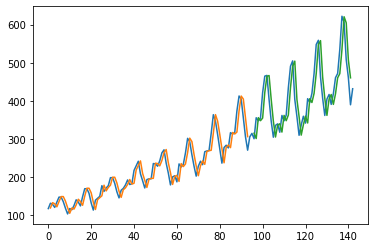

In [38]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the model did a pretty poor job of fitting both the training and the test
datasets. It basically predicted the same input value as the output.